In [1]:
!pip install vnstock3 pandas_ta tensorflow scikit-learn statsmodels pmdarima prophet


[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: C:\Users\thien\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
# Set environment variable
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from vnstock3 import Vnstock
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import F  # Assuming 'F' is a module you've created
import matplotlib.pyplot as plt

C:\Users\thien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# Get current date
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")

# Fetch VN30 and VNI stock data
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end=current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end=current_date, to_df=True)

2024-07-06 11:33:09,244 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-07-06 11:33:10,232 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [4]:
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)
    data['rsi'] = ta.rsi(data['close'], length=14)
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        LSTM(100),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=input_shape),
        GRU(100),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def prepare_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

def model_LSTM(data, time_steps=60, epochs=50, batch_size=64):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    
    X, y = prepare_data(data_scaled, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    model = create_lstm_model((time_steps, data_features.shape[1]))
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, scaler, time_steps

def model_GRU(data, time_steps=60, epochs=50, batch_size=64):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    
    X, y = prepare_data(data_scaled, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    model = create_gru_model((time_steps, data_features.shape[1]))
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model, scaler, time_steps

def model_Prophet(data):
    prophet_data = data[['time', 'close']].rename(columns={'time': 'ds', 'close': 'y'})
    model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model.fit(prophet_data)
    return model

def output_Prophet(model, current_time):
    future = pd.DataFrame({'ds': [current_time]})
    forecast = model.predict(future)
    predicted_price = forecast['yhat'].values[0]
    return predicted_price

def output_LSTM(model, scaler, data, time_steps=60):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    data_scaled = scaler.transform(data_features)
    
    X = np.array([data_scaled[-time_steps:]])
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    predicted_price = model.predict(X)
    predicted_price = scaler.inverse_transform(np.concatenate([predicted_price, np.zeros((predicted_price.shape[0], data_features.shape[1]-1))], axis=1))[:, 0]
    
    return predicted_price[0]

def output_GRU(model, scaler, data, time_steps=60):
    data_features = data[['close', 'sma5', 'sma10', 'ema5', 'ema10', 'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']].values
    data_scaled = scaler.transform(data_features)
    
    X = np.array([data_scaled[-time_steps:]])
    X = X.reshape(X.shape[0], X.shape[1], data_features.shape[1])
    
    predicted_price = model.predict(X)
    predicted_price = scaler.inverse_transform(np.concatenate([predicted_price, np.zeros((predicted_price.shape[0], data_features.shape[1]-1))], axis=1))[:, 0]
    
    return predicted_price[0]

def voting_decision(predictions):
    votes = [0, 0]  # [long_votes, short_votes]
    for pred in predictions:
        if pred > 2:
            votes[0] += 1
        elif pred < -2:
            votes[1] += 1
    if votes[0] > votes[1]:
        return 1
    elif votes[1] > votes[0]:
        return -1
    else:
        return 0

def test(data, k):
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Initialize models
    model_lstm, scaler_lstm, time_steps_lstm = model_LSTM(data, time_steps=k)
    model_gru, scaler_gru, time_steps_gru = model_GRU(data, time_steps=k)
    model_prophet = model_Prophet(data)
    
    for i in range(k, len(data)):
        historical_data = data.iloc[i-k:i]
        current_time = data.iloc[i]['time']
        
        lstm_pred = output_LSTM(model_lstm, scaler_lstm, historical_data, time_steps_lstm)
        gru_pred = output_GRU(model_gru, scaler_gru, historical_data, time_steps_gru)
        prophet_pred = output_Prophet(model_prophet, current_time)
        
        predictions = [lstm_pred - data.iloc[i-1]['close'],
                       gru_pred - data.iloc[i-1]['close'],
                       prophet_pred - data.iloc[i-1]['close']]
        
        data_output.loc[i, 'position'] = voting_decision(predictions)
    
    data_output.dropna(inplace=True)
    return data_output

def plot_pnl_with_annotation(data, symbol):
    backtesting = F.BacktestInformation(data['time'], data['position'], data['close'])
    pnl_data = backtesting.Plot_PNL(plot=False)
    
    # Plot PNL
    plt.figure(figsize=(15, 6))
    pnl_data['total_gain'].plot(label='Total Gain')
    pnl_data['total_gain_after_fee'].plot(label='Total Gain After Fee')

    plt.title(f'PNL for {symbol}')
    plt.xlabel('Time')
    plt.ylabel('PNL')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Stock: {symbol}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
    plt.show()

Epoch 1/50
14/14 [==============================] - 9s 196ms/step - loss: 0.1809
Epoch 2/50
14/14 [==============================] - 3s 180ms/step - loss: 0.0429
Epoch 3/50
14/14 [==============================] - 2s 151ms/step - loss: 0.0310
Epoch 4/50
14/14 [==============================] - 2s 152ms/step - loss: 0.0261
Epoch 5/50
14/14 [==============================] - 2s 164ms/step - loss: 0.0237
Epoch 6/50
14/14 [==============================] - 2s 160ms/step - loss: 0.0223
Epoch 7/50
14/14 [==============================] - 2s 145ms/step - loss: 0.0207
Epoch 8/50
14/14 [==============================] - 2s 146ms/step - loss: 0.0200
Epoch 9/50
14/14 [==============================] - 2s 150ms/step - loss: 0.0196
Epoch 10/50
14/14 [==============================] - 2s 157ms/step - loss: 0.0182
Epoch 11/50
14/14 [==============================] - 2s 159ms/step - loss: 0.0177
Epoch 12/50
14/14 [==============================] - 2s 149ms/step - loss: 0.0172
Epoch 13/50
14/14 [======

11:36:42 - cmdstanpy - INFO - Chain [1] start processing
11:36:43 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 25ms/step
Epoch 1/50
14/14 [==============================] - 7s 156ms/step - loss: 0.2503
Epoch 2/50
14/14 [==============================] - 2s 151ms/step - loss: 0.0500
Epoch 3/50
14/14 [==============================] - 2s 147ms/step - loss: 0.0279
Epoch 4/50
14/14 [==============================] - 2s 146ms/step - loss: 0.0243
Epoch 5/50
14/14 [==============================] - 2s 147ms/step - loss: 0.0201
Epoch 6/50
14/14 [==============================] - 2s 150ms/step - loss: 0.0195
Epoch 7/50
14/14 [==============================] - 2s 147ms/step - loss: 0.0188
Epoch 8/50
14/14 [==============================] - 2s 149ms/step - loss: 0.0173
Epoch 9/50
14/14 [==============================] - 2s 149ms/step - loss: 0.0162
Epoch 10/50
14/14 [==============================] - 2s 150ms/step - loss: 0.0156
Epoch 11/50
14/14 [==============================] - 2s 148ms/step - loss: 0.0151
Epoch 12/50
14/14 [==============================] - 2s

11:42:58 - cmdstanpy - INFO - Chain [1] start processing
11:42:59 - cmdstanpy - INFO - Chain [1] done processing


1/1 [==============================] - 0s 26ms/step


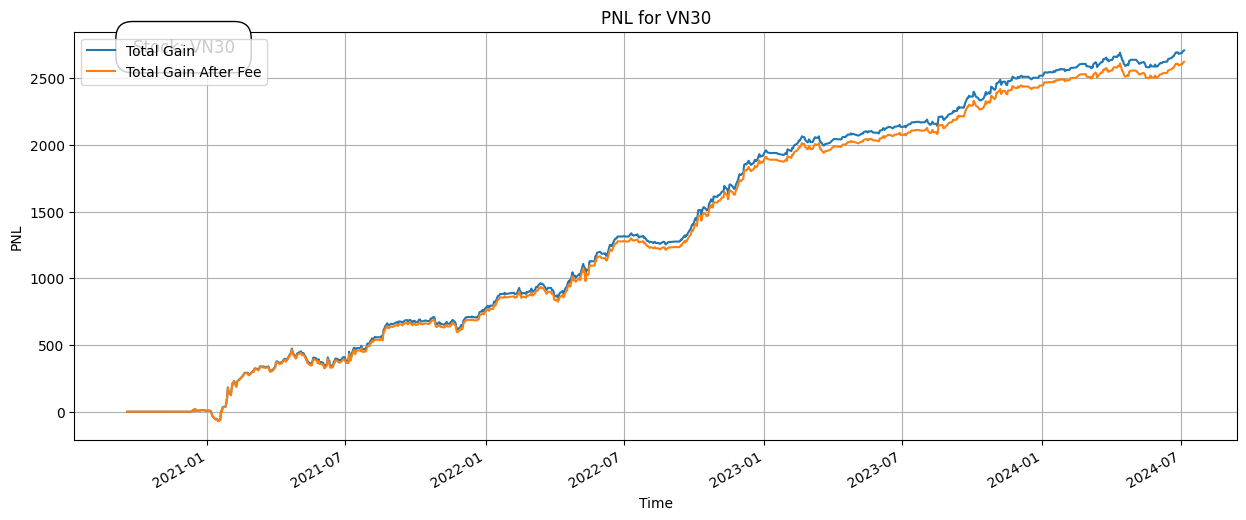

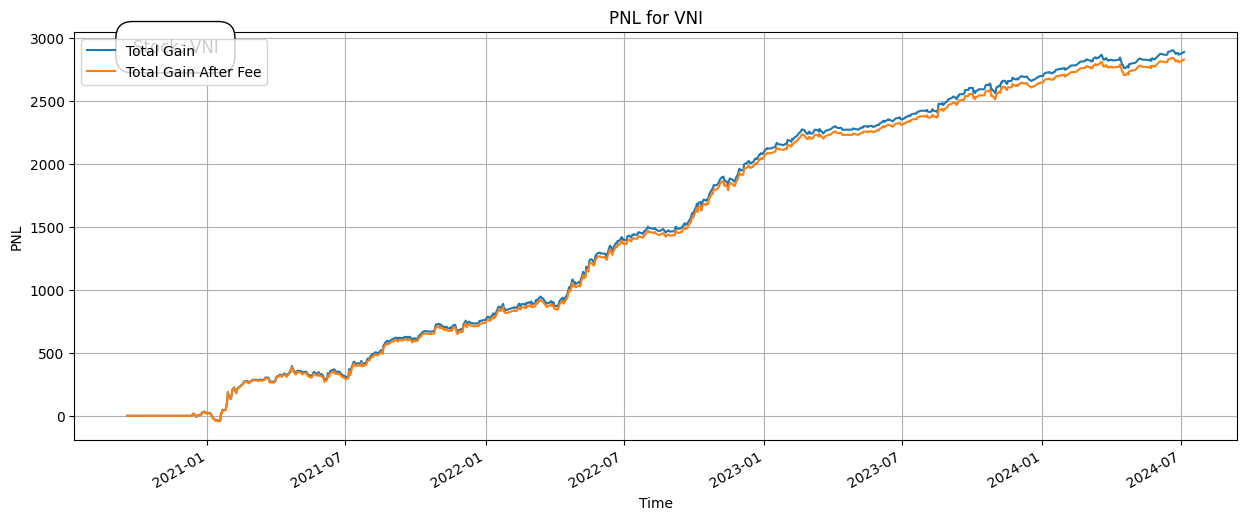

Backtesting Results for VN30
Margin: 56.01032422195661
MDD: (151.53774261603382, 0.09889948220646493)

   Total trading quantity: 194
         Profit per trade: 13.969020618556701
             Total Profit: 2710.0
         Profit after fee: 2623.9
 Trading quantity per day: 0.20464135021097046
 Profit per day after fee: 2.7678270042194093
                   Return: 0.45064741815903514
          Profit per year: 690.5
                  HitRate: 0.6443298969072165
          HitRate per day: 0.46673706441393875


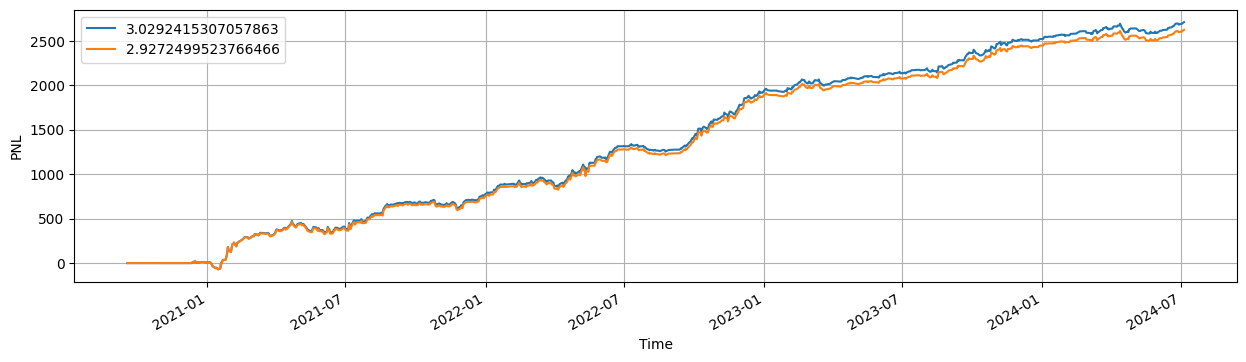

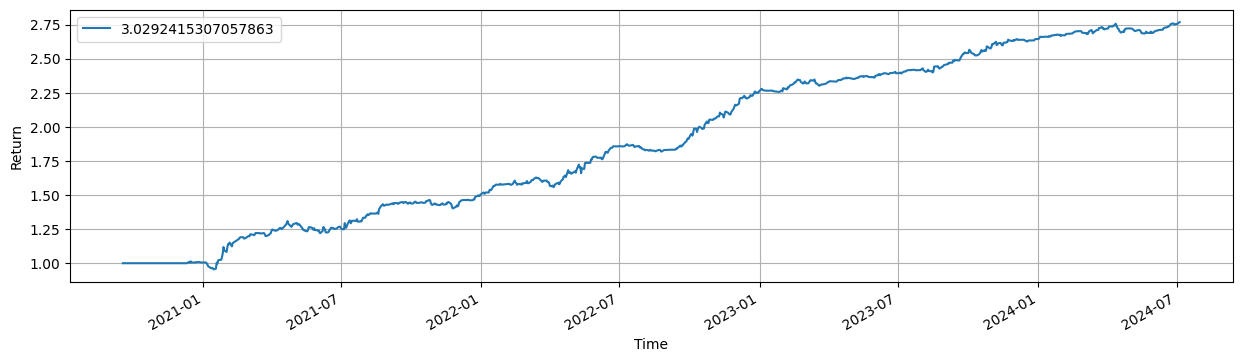

Backtesting Results for VNI
Margin: 84.06830670401158
MDD: (92.91632911392367, 0.0620153303213843)

   Total trading quantity: 141
         Profit per trade: 20.507446808510647
             Total Profit: 2891.6
         Profit after fee: 2830.8
 Trading quantity per day: 0.14873417721518986
 Profit per day after fee: 2.986075949367089
                   Return: 0.4972017035674592
          Profit per year: 744.9473684210527
                  HitRate: 0.6879432624113475
          HitRate per day: 0.5005279831045406


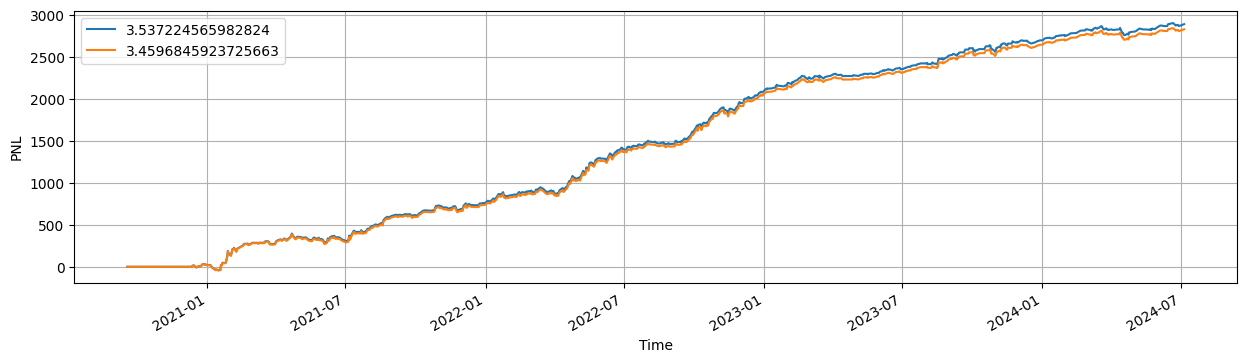

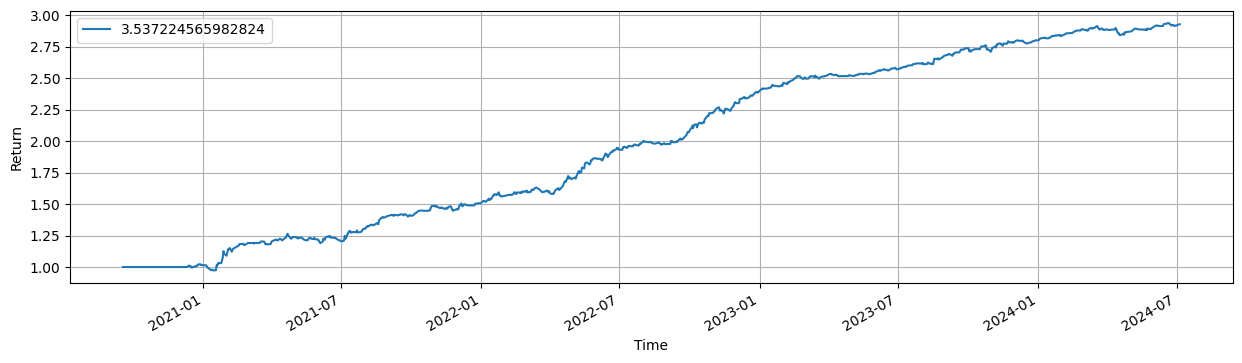

,total_gain,fee,total_gain_after_fee,Position,Close,Return
Datetime,,,,,,
2020-09-18,0.00,0.000000,0.000000,0,900.95,1.000000
2020-09-21,0.00,0.000000,0.000000,0,907.94,1.000000
2020-09-22,0.00,0.000000,0.000000,0,906.19,1.000000
2020-09-23,0.00,0.000000,0.000000,0,912.50,1.000000
2020-09-24,0.00,0.000000,0.000000,0,908.58,1.000000
...,...,...,...,...,...,...
2024-07-01,2878.30,60.581013,2817.718987,0,1254.56,2.921069
2024-07-02,2878.30,60.797373,2817.502627,1,1269.79,2.921069
2024-07-03,2885.36,60.797373,2824.562627,1,1276.85,2.925782


In [5]:
# Run the backtesting for VN30 and VNI
data_VNI_position = test(data_VNI, 60)
data_VN30_position = test(data_VN30, 60)

plot_pnl_with_annotation(data_VN30_position, 'VN30')
plot_pnl_with_annotation(data_VNI_position, 'VNI')

# Print backtesting results
backtesting_VN30 = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtesting_VNI = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])

print("Backtesting Results for VN30")
backtesting_VN30.Plot_PNL()

print("Backtesting Results for VNI")
backtesting_VNI.Plot_PNL()